# Download keggle data

In [1]:
!pip install kaggle
from google.colab import files
files.upload()

Saving kaggle.json to kaggle (1).json


{'kaggle.json': b'{"username":"santaj9110","key":"166eaf611fe5389ea47fd23cfaeccc95"}'}

In [2]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
# Permission Warning 이 일어나지 않도록 
!chmod 600 ~/.kaggle/kaggle.json
# 본인이 참가한 모든 대회 보기 
!kaggle competitions list

ref                                            deadline             category            reward  teamCount  userHasEntered  
---------------------------------------------  -------------------  ---------------  ---------  ---------  --------------  
contradictory-my-dear-watson                   2030-07-01 23:59:00  Getting Started     Prizes         77           False  
gan-getting-started                            2030-07-01 23:59:00  Getting Started     Prizes        108           False  
store-sales-time-series-forecasting            2030-06-30 23:59:00  Getting Started  Knowledge        908           False  
tpu-getting-started                            2030-06-03 23:59:00  Getting Started  Knowledge        178           False  
digit-recognizer                               2030-01-01 00:00:00  Getting Started  Knowledge       1898           False  
titanic                                        2030-01-01 00:00:00  Getting Started  Knowledge      13391           False  
house-pr

In [3]:
! kaggle competitions download -c competitive-data-science-predict-future-sales

item_categories.csv: Skipping, found more recently modified local copy (use --force to force download)
items.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
shops.csv: Skipping, found more recently modified local copy (use --force to force download)
sample_submission.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
test.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
sales_train.csv.zip: Skipping, found more recently modified local copy (use --force to force download)


In [4]:
!unzip sales_train.csv.zip
!unzip items.csv.zip
!unzip test.csv.zip
!unzip  sample_submission.csv.zip


Archive:  sales_train.csv.zip
replace sales_train.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
Archive:  items.csv.zip
replace items.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: N
Archive:  test.csv.zip
replace test.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: N
Archive:  sample_submission.csv.zip
replace sample_submission.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [5]:
!ls

 item_categories.csv   sales_train.csv		   shops.csv
 items.csv	       sales_train.csv.zip	   subb2.csv
 items.csv.zip	       sample_data		   test.csv
'kaggle (1).json'      sample_submission.csv	   test.csv.zip
 kaggle.json	       sample_submission.csv.zip


# Library and read

In [6]:
!pip install category_encoders
!pip install eli5
!pip install pdpbox

In [7]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import iqr
from category_encoders import OrdinalEncoder,OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from xgboost import XGBRegressor
import eli5
from eli5.sklearn import PermutationImportance
from sklearn.metrics import mean_absolute_error ,r2_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import RidgeCV
from sklearn.preprocessing import StandardScaler
from pdpbox import pdp
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.formula.api import ols

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [8]:
categories = pd.read_csv('item_categories.csv')
items = pd.read_csv('items.csv')
train=pd.read_csv('sales_train.csv')
test = pd.read_csv('test.csv')
shops= pd.read_csv('shops.csv')
sample_sub=pd.read_csv('sample_submission.csv')

In [9]:
pd.options.display.float_format = '{:.3f}'.format

#EDA

## Data Wrangling

In [10]:
train.dtypes

date               object
date_block_num      int64
shop_id             int64
item_id             int64
item_price        float64
item_cnt_day      float64
dtype: object

### Missing values

In [11]:
# check if there are missing values 
train.isnull().sum()

date              0
date_block_num    0
shop_id           0
item_id           0
item_price        0
item_cnt_day      0
dtype: int64

In [12]:
# test
test.isnull().sum()

ID         0
shop_id    0
item_id    0
dtype: int64

### Duplicated data

In [13]:
# check
print((train.duplicated()==True).sum())

# Delete
train.drop_duplicates(keep='first',inplace=True)

6


In [14]:
# test
print((test.duplicated()==True).sum())

0


### Outlier

#### check- plot

[Text(0.5, 1.0, 'item_cnt_day')]

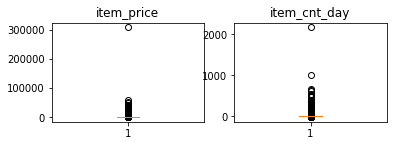

In [15]:
# plot
fig= plt.figure()

ax1=fig.add_subplot(2,2,1)
plt.boxplot(train.item_price);

ax2=fig.add_subplot(2,2,2)
plt.boxplot(train.item_cnt_day);

ax1.set(title="item_price")
ax2.set(title="item_cnt_day")

#### Item_price

##### Analyzation

In [16]:
train.item_price.describe()

count   2935843.000
mean        890.853
std        1729.801
min          -1.000
25%         249.000
50%         399.000
75%         999.000
max      307980.000
Name: item_price, dtype: float64

##### Delete neg values

In [17]:
# check how many neg values are
print((train.item_price <0).sum())

# Delete neg values
train= train[train.item_price>=0]
train.item_price.sort_values()

1


579766         0.070
608763         0.070
611400         0.087
673155         0.090
715120         0.100
             ...    
2931380    42990.000
2327159    49782.000
1488135    50999.000
885138     59200.000
1163158   307980.000
Name: item_price, Length: 2935842, dtype: float64

##### IQR 

In [18]:
# Make highest and lowest line to remove outlier
q3_pr= np.percentile(train.item_price,0.75)
iqr_pr=iqr(train.item_price)
q1_pr=q3_pr-iqr_pr
highest_pr=q3_pr + 1.5*iqr_pr
lowest_pr=q1_pr-1.5*iqr_pr

In [19]:
# check before delete
train[(train.item_price> highest_pr) | (train.item_price< lowest_pr)].count()

date              620059
date_block_num    620059
shop_id           620059
item_id           620059
item_price        620059
item_cnt_day      620059
dtype: int64

--------It could delete too many data------

##### Delete values over 99 percent

In [20]:
# Too high values are still in Datas 0.5~99.5 
# so i delete values over 99%
a=np.percentile(train.item_price,99)
train[(train.item_price> a)].count()
# delete
train= train[train.item_price< a]

In [21]:
train

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.000,1.000
1,03.01.2013,0,25,2552,899.000,1.000
2,05.01.2013,0,25,2552,899.000,-1.000
3,06.01.2013,0,25,2554,1709.050,1.000
4,15.01.2013,0,25,2555,1099.000,1.000
...,...,...,...,...,...,...
2935844,10.10.2015,33,25,7409,299.000,1.000
2935845,09.10.2015,33,25,7460,299.000,1.000
2935846,14.10.2015,33,25,7459,349.000,1.000
2935847,22.10.2015,33,25,7440,299.000,1.000


#### Item_cnt_day

##### Analyzation

In [22]:
train.item_cnt_day.describe()

count   2906299.000
mean          1.242
std           2.621
min         -22.000
25%           1.000
50%           1.000
75%           1.000
max        2169.000
Name: item_cnt_day, dtype: float64

##### Delete neg values

In [23]:
# There can not be negative values in item_cnt_day feature

# check how many neg values are
print((train.item_cnt_day <0).sum())

# Percentage
print("%0.2f%%" %((train.item_cnt_day <0).sum()/train.item_cnt_day.sum()*100))

# Delete neg values

train= train[train.item_cnt_day>=0]

# item_cnt_day = number of products sold
train.item_cnt_day.astype('int')

7160
0.20%


0          1
1          1
3          1
4          1
5          1
          ..
2935844    1
2935845    1
2935846    1
2935847    1
2935848    1
Name: item_cnt_day, Length: 2899139, dtype: int64

##### IQR

In [24]:
# Make highest and lowest line to remove outlier
q3_day= np.percentile(train.item_cnt_day,0.75)
iqr_day=iqr(train.item_cnt_day)
q1_day=q3_day-iqr_day
highest_day=q3_day + 1.5*iqr_day
lowest_day=q1_day-1.5*iqr_day

In [25]:
highest_day,lowest_day

(1.0, 1.0)

highest and lowest values are 1. so if we use this, only one value will be left

##### Delete values over 99 percent

In [26]:
b=np.percentile(train.item_cnt_day,99)
train[(train.item_cnt_day> b)].count()
#delete
train= train[train.item_cnt_day< b]

### Touch up date

In [27]:
sp_date=train['date'].str.split(pat=".")

In [28]:
# change date's order
train['year']= sp_date.map(lambda x: x[2])
train['month']= sp_date.map(lambda x: x[1])
train['day']=sp_date.map(lambda x: x[0])

train['date']= train.year+train.month+train.day

train.drop(columns='day',inplace=True)
train.drop(columns='month',inplace=True)
train.drop(columns='year',inplace=True)

# change date's type
pd.to_datetime(train['date'])


0         2013-01-02
1         2013-01-03
3         2013-01-06
4         2013-01-15
5         2013-01-10
             ...    
2935844   2015-10-10
2935845   2015-10-09
2935846   2015-10-14
2935847   2015-10-22
2935848   2015-10-03
Name: date, Length: 2861792, dtype: datetime64[ns]

##Create features

### Concat train and test

In [29]:
## The date of test set is November 2015
## date_block_number= 34

test['date_block_num']=34

In [30]:
train=pd.concat([train,test])

### 1.Create: city

In [31]:
# Extract city name
shops['city'] = shops['shop_name'].apply(lambda x: x.split()[0])
# Adjust city's name
shops.loc[shops['city']=='!Якутск','city']='Якутск'

# Drop shop_name
shops.drop(columns='shop_name',inplace=True)

### 2.Create: type ,sub type

In [32]:
#split
sp_cats= categories['item_category_name'].str.split(pat="-")
sp_cats

0      [PC ,  Гарнитуры/Наушники]
1             [Аксессуары ,  PS2]
2             [Аксессуары ,  PS3]
3             [Аксессуары ,  PS4]
4             [Аксессуары ,  PSP]
                 ...             
79                    [Служебные]
80          [Служебные ,  Билеты]
81      [Чистые носители (шпиль)]
82    [Чистые носители (штучные)]
83             [Элементы питания]
Name: item_category_name, Length: 84, dtype: object

In [33]:
# Strip whitespaces
categories['type']= sp_cats.apply(lambda x: x[0].strip())

# Adjust type's name
categories.loc[categories.type=='Игровые консоли','type']='Игры'
categories.loc[categories.type=='Игры Android','type']='Игры'
categories.loc[categories.type=='Игры MAC','type']='Игры'
categories.loc[categories.type=='Игры PC','type']='Игры'
categories.loc[categories.type=='Карты оплаты (Кино, Музыка, Игры)','type']='Карты оплаты'
categories.loc[categories.type=='Чистые носители (шпиль)','type']='Чистые носители'
categories.loc[categories.type=='Чистые носители (штучные)','type']='Чистые носители'

categories['subtype']=sp_cats.map(lambda x: x[1].strip() if len(x)>1 else x[0].strip())
# Drop item_category_name
categories.drop(columns='item_category_name',inplace=True)
categories

,item_category_id,type,subtype
0,0,PC,Гарнитуры/Наушники
1,1,Аксессуары,PS2
2,2,Аксессуары,PS3
3,3,Аксессуары,PS4
4,4,Аксессуары,PSP
...,...,...,...
79,79,Служебные,Служебные
80,80,Служебные,Билеты
81,81,Чистые носители,Чистые носители (шпиль)
82,82,Чистые носители,Чистые носители (штучные)


### 3.Create target : item_cnt_month

In [34]:
# Make group to creat item_cnt_month
group=train.groupby(['date_block_num','shop_id','item_id'])['item_cnt_day'].agg([sum])
# Merge
train = train.merge(group, on=['date_block_num','shop_id','item_id'], how='left')
# Rename
train.rename(columns={'sum':'item_cnt_month'},inplace=True)

target='item_cnt_month'

# Drop item_cnt_day
train.drop(columns='item_cnt_day',inplace=True);

#### Merge 1,2,3

In [35]:
# items + categories to join train data
items=items.merge(categories,on='item_category_id')

items.drop(columns='item_name',inplace=True)

In [36]:
train= train.merge(shops,on='shop_id',how='left')
train= train.merge(items,on='item_id',how='left')

### function : target-mean feature

In [37]:
## https://www.kaggle.com/hadeux/simple-lgbmregressor-baseline

def add_mean(df, idx_features):
    # Check base features
    assert (idx_features[0] == 'date_block_num') and \
           len(idx_features) in [2, 3]
    
    # Set derived feature name 
    if len(idx_features) == 2:
        feature_name = idx_features[1] + '_mean_sales'
    else:
        feature_name = idx_features[1] + '_' + idx_features[2] + '_mean_sales'
    
    # Get average monthly sales by grouping based on base features
    group = df.groupby(idx_features).agg({'item_cnt_month': 'mean'})
    group = group.reset_index()
    group = group.rename(columns={'item_cnt_month': feature_name})
    
    # Merge df with group based on idx_features
    df = df.merge(group, on=idx_features, how='left')
    
    return df

In [38]:
#target

## ['date_block_num', 'item_id']
train = add_mean(df=train, idx_features=['date_block_num', 'item_id'])

##['date_block_num', 'shop_id']
train = add_mean(df=train, idx_features=['date_block_num', 'shop_id'])

## ['date_block_num', 'item_category_id']
train = add_mean(df=train, idx_features=['date_block_num', 'item_category_id'])

## ['date_block_num', 'item_id', 'city']
train = add_mean(df=train, idx_features=['date_block_num', 'item_id', 'city'])

## ['date_block_num', 'shop_id', 'item_category_id']
train = add_mean(df=train, idx_features=['date_block_num', 'shop_id', 'item_category_id'])

## ['date_block_num', 'shop_id', 'subtype_code']
train = add_mean(df=train, idx_features=['date_block_num', 'shop_id', 'subtype'])


### function : price-mean feature

In [39]:
## https://www.kaggle.com/hadeux/simple-lgbmregressor-baseline

def add_mean_pr(df, idx_features):
    # Check base features
    assert (idx_features[0] == 'date_block_num') and \
           len(idx_features) in [2, 3]
    
    # Set derived feature name 
    if len(idx_features) == 2:
        feature_name = idx_features[1] + '_mean_price'
    else:
        feature_name = idx_features[1] + '_' + idx_features[2] + '_mean_price'
    
    # Get average monthly sales by grouping based on base features
    group = df.groupby(idx_features).agg({'item_price': 'mean'})
    group = group.reset_index()
    group = group.rename(columns={'item_price': feature_name})
    
    # Merge df with group based on idx_features
    df = df.merge(group, on=idx_features, how='left')
    
    return df

In [40]:
## price

## ['date_block_num', 'item_id']
train = add_mean_pr(df=train, idx_features=['date_block_num', 'item_id'])

##['date_block_num', 'shop_id']
train = add_mean_pr(df=train, idx_features=['date_block_num', 'shop_id'])

## ['date_block_num', 'item_category_id']
train = add_mean_pr(df=train, idx_features=['date_block_num', 'item_category_id'])

## ['date_block_num', 'item_id', 'city']
train = add_mean_pr(df=train, idx_features=['date_block_num', 'item_id', 'city'])

## ['date_block_num', 'shop_id', 'item_category_id']
train = add_mean_pr(df=train, idx_features=['date_block_num', 'shop_id', 'item_category_id'])

## ['date_block_num', 'shop_id', 'subtype_code']
train = add_mean_pr(df=train, idx_features=['date_block_num', 'shop_id', 'subtype'])

### Lag function

In [475]:
def lag(df,lags,col):
    tmp = df[['date_block_num','shop_id','item_id',col]]
    for i in lags:
        shifted = tmp.copy()
        shifted.columns=['date_block_num','shop_id','item_id', col+'_lag_'+str(i)]
        shifted['date_block_num'] += i
        df=pd.merge(df,shifted,on=['date_block_num','shop_id','item_id'],how='left')
    return df

In [476]:
"""
##lag
train= lag(train,[1],'item_id_mean_sales')
train= lag(train,[1],'shop_id_mean_sales')
train= lag(train,[1],'item_category_id_mean_sales')
train= lag(train,[1],'item_id_city_mean_sales')
train= lag(train,[1],'shop_id_item_category_id_mean_sales')
train= lag(train,[1],'shop_id_subtype_mean_sales')
"""

"\n##lag\ntrain= lag(train,[1],'item_id_mean_sales')\ntrain= lag(train,[1],'shop_id_mean_sales')\ntrain= lag(train,[1],'item_category_id_mean_sales')\ntrain= lag(train,[1],'item_id_city_mean_sales')\ntrain= lag(train,[1],'shop_id_item_category_id_mean_sales')\ntrain= lag(train,[1],'shop_id_subtype_mean_sales')\n"

In [477]:
"""
# lag price
train= lag(train,[1],'item_price')
"""

"\n# lag price\ntrain= lag(train,[1],'item_price')\n"

In [41]:
train.fillna(0,inplace=True)
train.drop(columns='ID',inplace=True)

### Check before modeling

#### Encoding for checking

In [42]:
encoding=OrdinalEncoder()
train_encoded=encoding.fit_transform(train)

#### 상관관계 히트맵

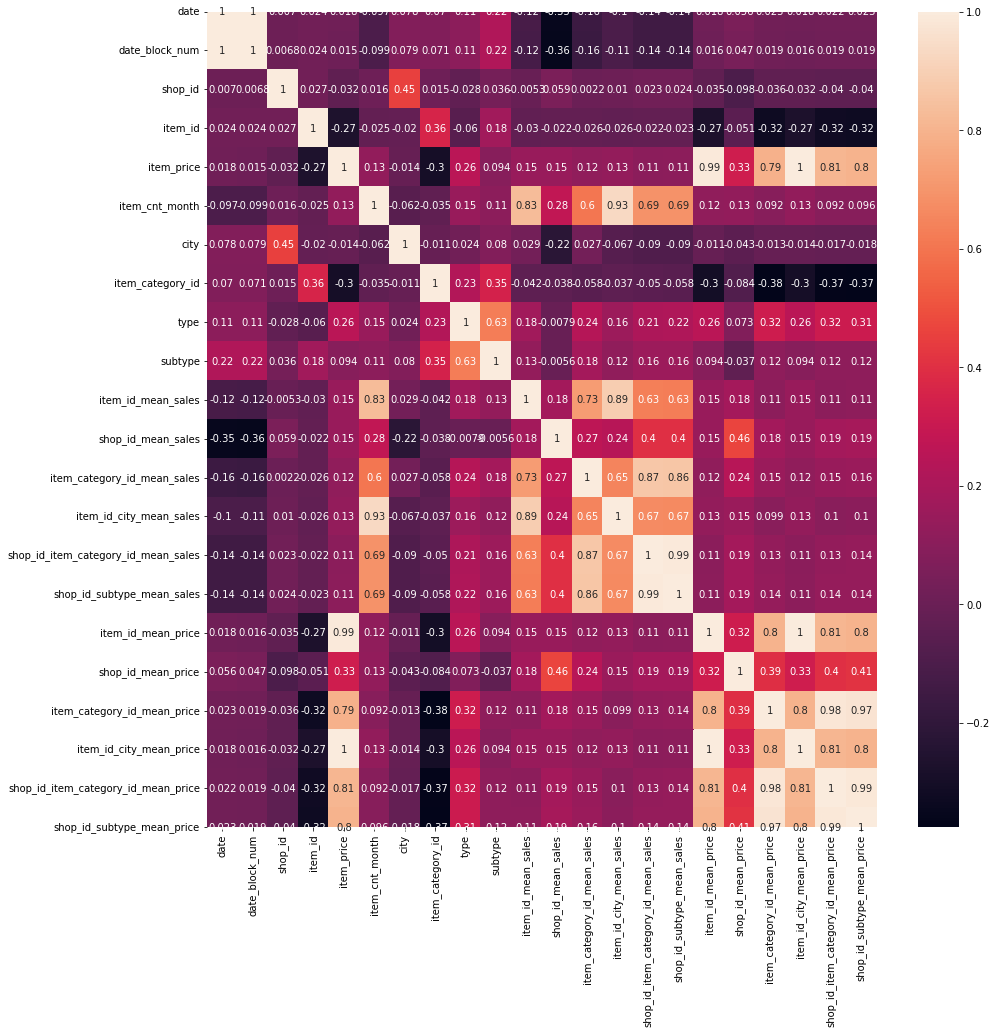

In [43]:
plt.figure(figsize=(15,15))

sns.heatmap(train_encoded.corr(),annot=True)

#### 다중공선성 확인- 피쳐 조합

In [44]:
# vif 10 이하로 피쳐 조합
features=['item_id_mean_sales','shop_id_mean_sales','item_id_city_mean_sales',\
          'shop_id_item_category_id_mean_sales','type','item_price','shop_id_mean_price',\
          'shop_id_subtype_mean_price','shop_id']
a=train_encoded[features]

vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(a.values, i) for i in range(a.shape[1])]
vif["features"] = a.columns
vif

,VIF Factor,features
0,8.409,item_id_mean_sales
1,9.534,shop_id_mean_sales
2,8.219,item_id_city_mean_sales
3,4.073,shop_id_item_category_id_mean_sales
4,3.376,type
5,4.895,item_price
6,9.947,shop_id_mean_price
7,6.779,shop_id_subtype_mean_price
8,3.729,shop_id


데이터 정리

In [45]:
df=train[features]
df[target]=train[target]

In [46]:
df['date_block_num']=train['date_block_num']

#Modeling

### Adjust features for modeling



In [47]:
val=df[df['date_block_num']==33]
test=df[df['date_block_num']==34]
train=df[df['date_block_num']<33]

train.drop(columns='date_block_num',inplace=True)
val.drop(columns='date_block_num',inplace=True)
test.drop(columns='date_block_num',inplace=True)

### baseline= mean

In [48]:
target= 'item_cnt_month'

X_train= train.drop(columns=target)
y_train=train[target]

X_val=val.drop(columns=target)
y_val=val[target]

test= test.drop(columns=target)

In [49]:
X_train.fillna(0,inplace=True)
X_val.fillna(0,inplace=True)

In [50]:
y_train.describe()

count   2810130.000
mean          4.770
std           6.860
min           1.000
25%           1.000
50%           2.000
75%           5.000
max          75.000
Name: item_cnt_month, dtype: float64

In [51]:
predict=y_train.mean()

y_pred= [predict]*len(y_train)
rmse= mean_squared_error(y_train,y_pred)**0.5

rmse

6.860145072198136

In [52]:
y_pred= [predict]*len(y_val)
rmse= mean_squared_error(y_val,y_pred)**0.5

rmse

7.100604978763966

### XGB

In [490]:
pipe =Pipeline([
                ('preprocessing',make_pipeline(OrdinalEncoder())),
                ('xg',XGBRegressor(n_estimators=100, random_state=2, n_jobs=-1))
])

In [491]:
pipe.named_steps

{'preprocessing': Pipeline(steps=[('ordinalencoder', OrdinalEncoder())]),
 'xg': XGBRegressor(n_jobs=-1, random_state=2)}

In [492]:
pipe.fit(X_train, y_train)

[08:54:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


Pipeline(steps=[('preprocessing',
                 Pipeline(steps=[('ordinalencoder',
                                  OrdinalEncoder(cols=['type'],
                                                 mapping=[{'col': 'type',
                                                           'data_type': dtype('O'),
                                                           'mapping': Кино                 1
Музыка               2
Игры                 3
Программы            4
Книги                5
Подарки              6
Аксессуары           7
Карты оплаты         8
Чистые носители      9
Служебные           10
PC                  11
Элементы питания    12
Доставка товара     13
Билеты (Цифра)      14
NaN                 -2
dtype: int64}]))])),
                ('xg', XGBRegressor(n_jobs=-1, random_state=2))])

In [493]:
## rmse
y_pred=pipe.predict(X_val)
rmse= mean_squared_error(y_val,y_pred)**0.5

rmse

1.4785850296872385

 r2 score

In [494]:
r2=r2_score(y_val,y_pred)

r2

0.9564502491509868

## PermutationImportance

In [495]:
permuter = PermutationImportance(
    pipe.named_steps['xg'],
    
    n_iter=30,
    random_state=2
)

X_val_transformed = pipe.named_steps['preprocessing'].transform(X_val)
permuter.fit(X_val_transformed, y_val);

In [496]:
feature_names = X_val.columns.tolist()
pd.Series(permuter.feature_importances_, feature_names).sort_values()

item_price                            0.000
shop_id_mean_price                    0.001
shop_id_subtype_mean_price            0.003
shop_id_mean_sales                    0.005
item_id_mean_sales                    0.006
type                                  0.007
shop_id                               0.013
shop_id_item_category_id_mean_sales   0.395
item_id_city_mean_sales               1.201
dtype: float64

In [497]:
eli5.show_weights(
    permuter, 
    top=None,
    feature_names=feature_names
)

Weight,Feature
1.2011 ± 0.0109,item_id_city_mean_sales
0.3947 ± 0.0074,shop_id_item_category_id_mean_sales
0.0130 ± 0.0004,shop_id
0.0066 ± 0.0004,type
0.0058 ± 0.0002,item_id_mean_sales
0.0047 ± 0.0003,shop_id_mean_sales
0.0028 ± 0.0003,shop_id_subtype_mean_price
0.0009 ± 0.0001,shop_id_mean_price
0.0002 ± 0.0000,item_price


### Delete features under 0.0001

In [59]:
## Delete features

minimum_importance =0.0001
mask=permuter.feature_importances_>=minimum_importance

features = X_train.columns[mask]
X_train_selected = X_train[features]
test_selected=test[features]
X_val_selected=X_val[features]

In [54]:
pipe =Pipeline([
                ('preprocessing',make_pipeline(OrdinalEncoder())),
                ('xg',XGBRegressor(n_estimators=100, random_state=2, n_jobs=-1))
])

In [55]:
pipe.fit(X_train_selected,y_train)

[04:19:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


Pipeline(steps=[('preprocessing',
                 Pipeline(steps=[('ordinalencoder',
                                  OrdinalEncoder(cols=['city', 'type'],
                                                 mapping=[{'col': 'city',
                                                           'data_type': dtype('O'),
                                                           'mapping': Ярославль            1
Москва               2
Курск                3
Красноярск           4
Волжский             5
Воронеж              6
Адыгея               7
Балашиха             8
Якутск               9
Коломна             10
Калуга              11
Жуковский           12
Казань              13
Интернет-магазин    14
Уфа                 15
Н.Новгород          16
Чехов               17
Химки               18
Сургут              19
Тюмень              20
СПб                 21
РостовНаДон...
Самара              24
Новосибирск         25
Сергиев             26
Вологда             27
Цифровой            28
В

In [56]:
y_pred=pipe.predict(X_val_selected)
rmse= mean_squared_error(y_val,y_pred)**0.5

rmse

1.4040263023966566

## gradient boosting regressor


In [499]:
encoder = OrdinalEncoder()

X_train_encoded = encoder.fit_transform(X_train)
X_val_encoded = encoder.transform(X_val)

boosting = XGBRegressor(
    n_estimators=1000,
    objective='reg:squarederror',
    learning_rate=0.2,
    n_jobs=-1
)

eval_set=[(X_train_encoded,y_train),(X_val_encoded,y_val)]

boosting.fit(X_train_encoded,y_train,
             eval_set=eval_set,
             early_stopping_rounds=50
)

## [195]	validation_0-rmse:3.80279	validation_1-rmse:3.43746

[0]	validation_0-rmse:6.65841	validation_1-rmse:6.58531
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 50 rounds.
[1]	validation_0-rmse:5.559	validation_1-rmse:5.43527
[2]	validation_0-rmse:4.70385	validation_1-rmse:4.53856
[3]	validation_0-rmse:4.04407	validation_1-rmse:3.87306
[4]	validation_0-rmse:3.53823	validation_1-rmse:3.36334
[5]	validation_0-rmse:3.16208	validation_1-rmse:2.95935
[6]	validation_0-rmse:2.87362	validation_1-rmse:2.64738
[7]	validation_0-rmse:2.671	validation_1-rmse:2.44509
[8]	validation_0-rmse:2.51808	validation_1-rmse:2.27663
[9]	validation_0-rmse:2.40329	validation_1-rmse:2.15851
[10]	validation_0-rmse:2.32289	validation_1-rmse:2.0753
[11]	validation_0-rmse:2.26132	validation_1-rmse:1.98631
[12]	validation_0-rmse:2.21921	validation_1-rmse:1.95548
[13]	validation_0-rmse:2.18042	validation_1-rmse:1.92113
[14]	validation_0-rmse:2.15463	validation_1-rmse:1.86429
[

XGBRegressor(learning_rate=0.2, n_estimators=1000, n_jobs=-1,
             objective='reg:squarederror')

In [500]:
y_pred = boosting.predict(X_val_encoded)
print('R^2', r2_score(y_val, y_pred))

R^2 0.966262575313303


to csv

In [501]:
test_encoded= encoder.fit_transform(test)

y_pred=boosting.predict(test_encoded)

In [502]:
a=pd.DataFrame(y_pred).reset_index()

In [503]:
a.rename(columns={'index':'ID',0:'item_cnt_month'},inplace=True)

In [504]:
a.to_csv(path_or_buf='subb2.csv',index=False)

## Decision tree regressor 

In [53]:

pipe = make_pipeline(
    OrdinalEncoder(),  
    DecisionTreeRegressor(min_samples_split=2,
                          min_samples_leaf=2,
                          max_features=5
                          )
)



pipe.fit(X_train, y_train);

In [54]:
y_pred=pipe.predict(X_val)
rmse= mean_squared_error(y_val,y_pred)**0.5

rmse

2.132096680349597

In [55]:
r2=r2_score(y_val,y_pred)

r2

0.9094461638485509

## RidgeCV

In [56]:
pipe =make_pipeline(
    OrdinalEncoder(),
    RidgeCV(cv=3)
)

pipe.fit(X_train,y_train)

Pipeline(steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['type'],
                                mapping=[{'col': 'type',
                                          'data_type': dtype('O'),
                                          'mapping': Кино                 1
Музыка               2
Игры                 3
Программы            4
Книги                5
Подарки              6
Аксессуары           7
Карты оплаты         8
Чистые носители      9
Служебные           10
PC                  11
Элементы питания    12
Доставка товара     13
Билеты (Цифра)      14
NaN                 -2
dtype: int64}])),
                ('ridgecv', RidgeCV(alphas=array([ 0.1,  1. , 10. ]), cv=3))])

In [57]:
y_pred=pipe.predict(X_val)

r2=r2_score(y_val,y_pred)

r2

0.9136995330898

In [58]:
y_pred=pipe.predict(X_val)
rmse= mean_squared_error(y_val,y_pred)**0.5

rmse

2.081421518217227

standard scaled

In [59]:
pipe =make_pipeline(
    OneHotEncoder(use_cat_names=True),
    StandardScaler(),
    RidgeCV(cv=5)
)

pipe.fit(X_train,y_train)

Pipeline(steps=[('onehotencoder',
                 OneHotEncoder(cols=['type'], use_cat_names=True)),
                ('standardscaler', StandardScaler()),
                ('ridgecv', RidgeCV(alphas=array([ 0.1,  1. , 10. ]), cv=5))])

In [60]:
y_pred=pipe.predict(X_val)

r2=r2_score(y_val,y_pred)

r2

0.9140291091417516

# PDP

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


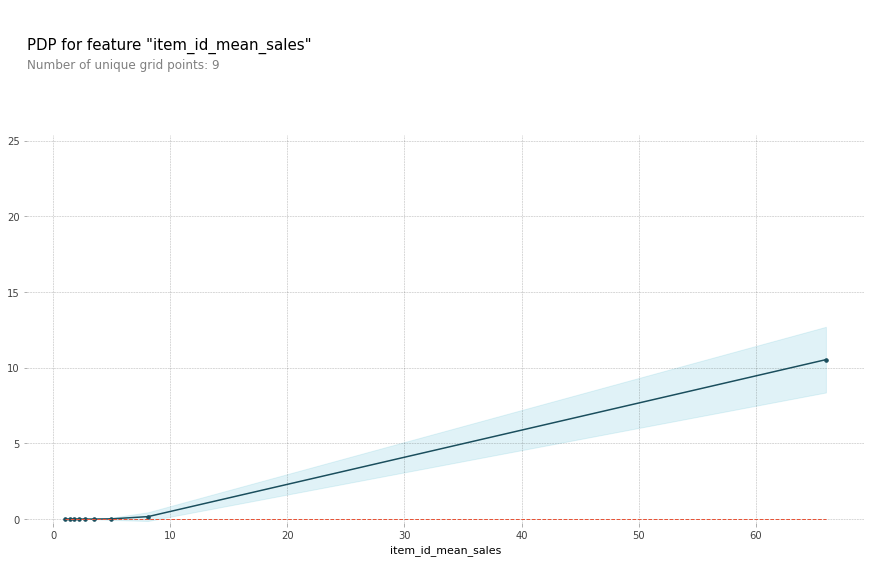

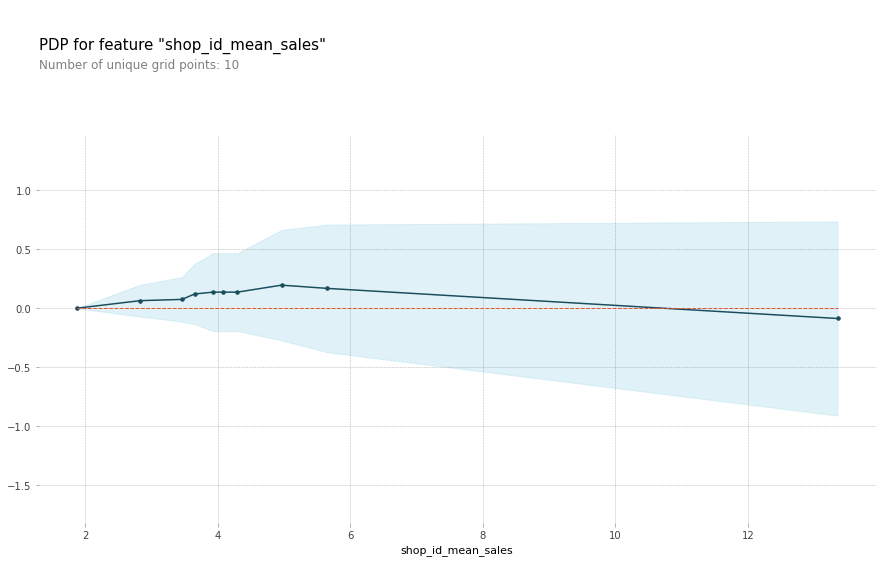

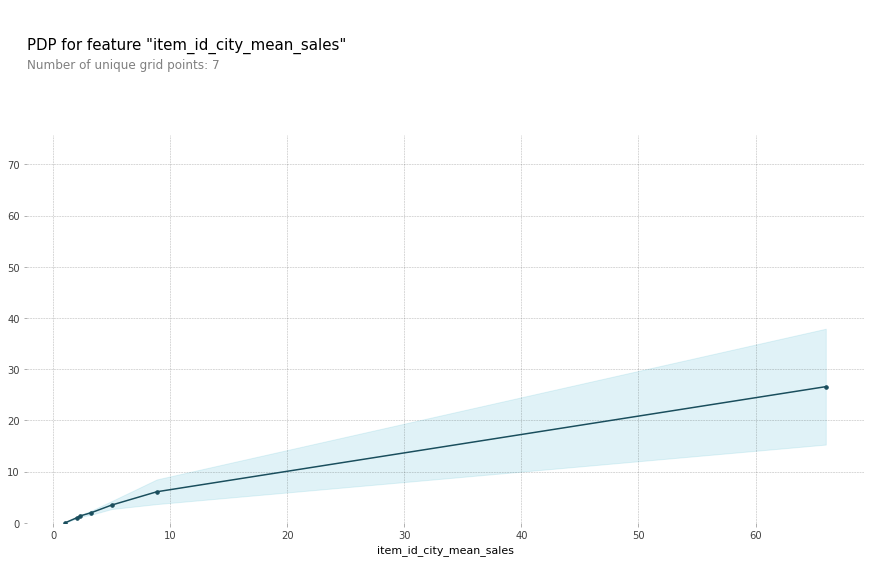

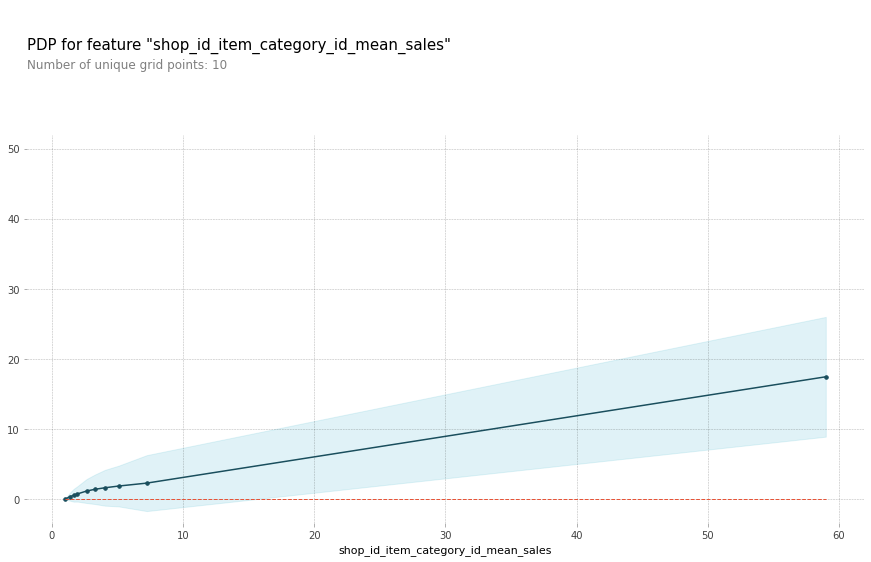

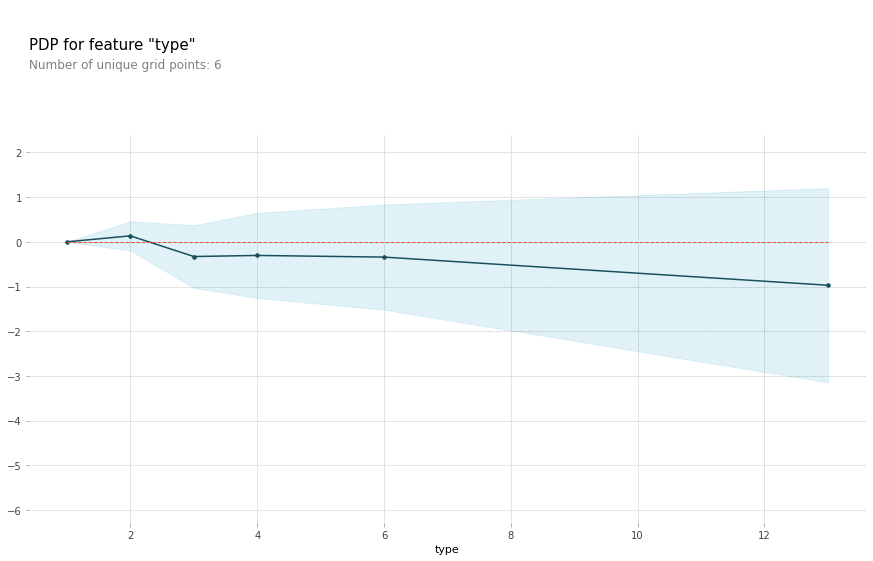

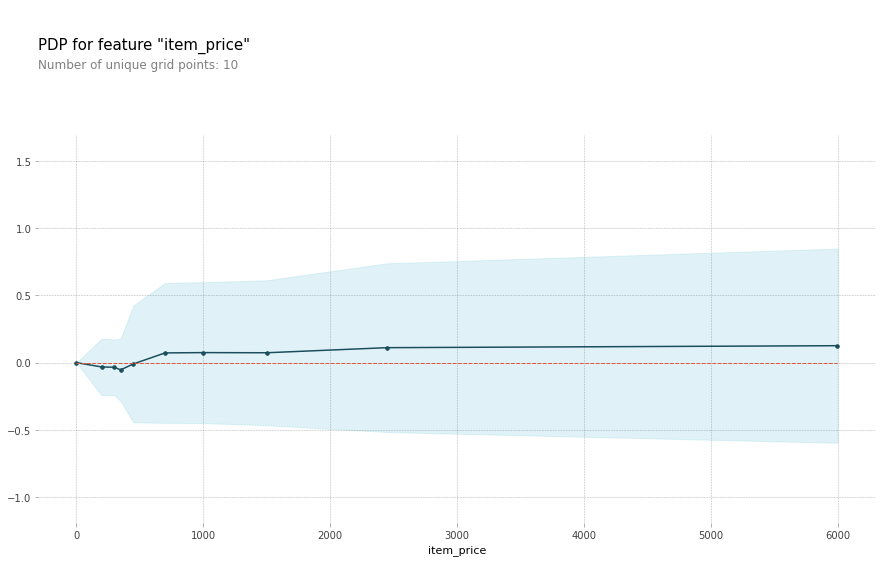

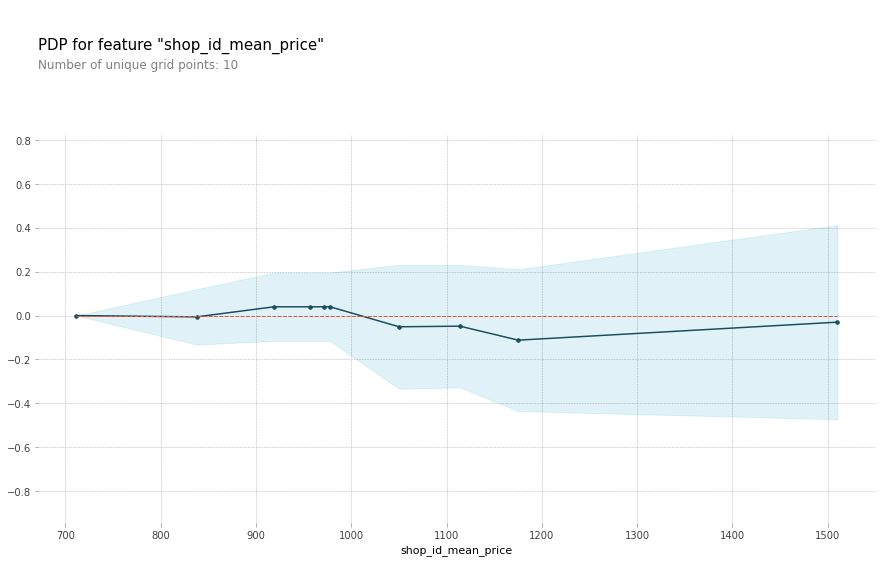

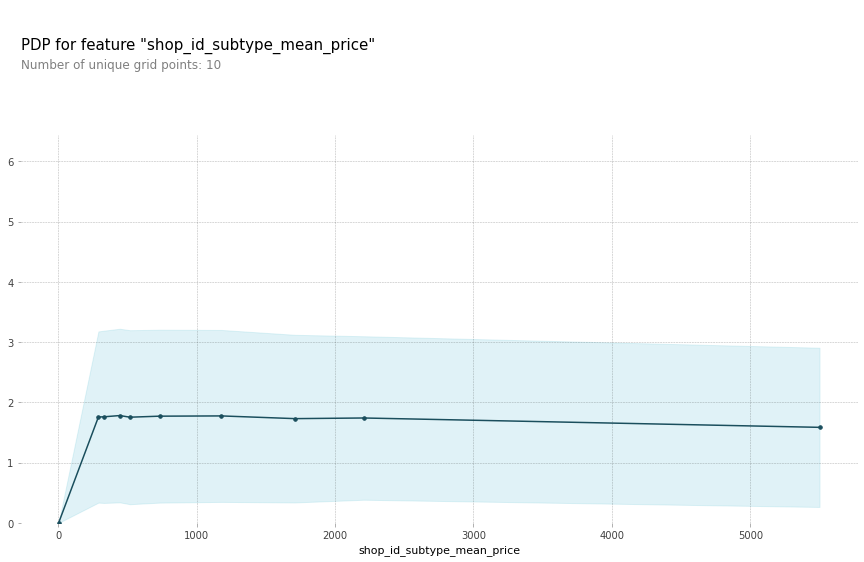

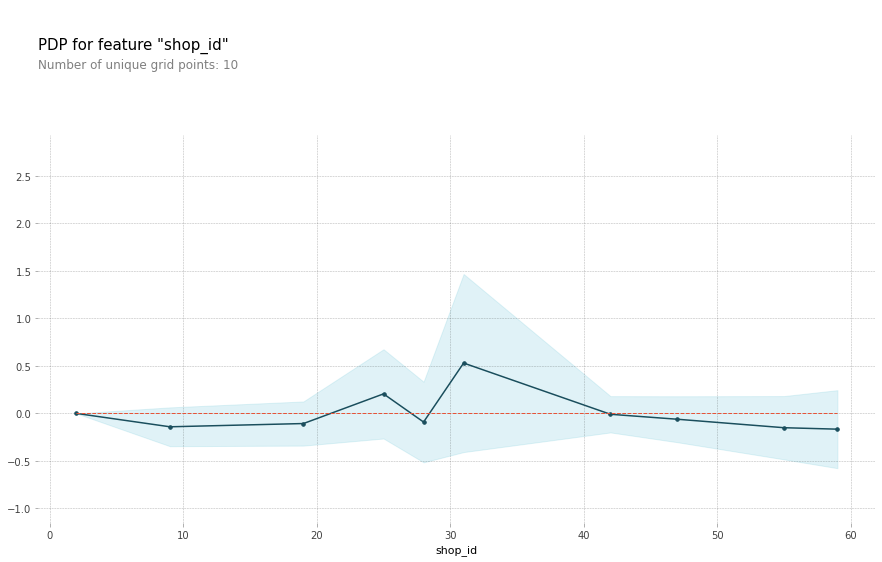

In [516]:
for i in X_train.columns:
    feature = i
    features = X_val_encoded.columns
    pdp_dist = pdp.pdp_isolate(model=boosting, dataset=X_val_encoded, model_features=features, feature=feature)
    pdp.pdp_plot(pdp_dist, feature);